# Computing Coursework

#### I am importing all the libraries I will need

In [1]:
import numpy as np # For carrying out array and numerical computations
import matplotlib.pyplot as plt # For plotting static visualisation
import matplotlib.animation as anim  # For plotting animated visualisation
from mpl_toolkits.mplot3d import Axes3D  # For 3D plots
import scipy.sparse as sp
import scipy.sparse.linalg as spla # Both sp, spla used for sparse matrix operations and solving linear systems in the implicit method.

#### I am setting the domain of solution and the discretised grid

In [2]:
'The wave equation is solved on a 1m * 1m square grid over 3 seconds'
L = 1.0          # Length of the square domain (both x and y directions)
T = 3.0          # Total simulation time
c = 1.0          # Wave speed (constant)

In [3]:
'Discretising the domain'
nx, ny = 51, 51          # Number of grid points in x and y directions (Domain divided into 51*51 points)
dx = L / (nx - 1)        # Grid spacing in x-direction 
dy = dx                  # Grid spacing in y-direction (where dy = dx)

'Time stepping'
dt_exp = 0.005           # Time step for explicit finite difference method (have to satisfy CFL condition)
dt_impl = 0.01           # Time step for implicit method
CFL = c * dt_exp / dx    # Courant number (stability condition)
nt_exp = int(T / dt_exp) + 1  # Total explicit time steps
nt_impl = int(T / dt_impl) + 1  # Total implicit time steps

'Create spatial grid'
x = np.linspace(0, L, nx) 
y = np.linspace(0, L, ny) # Gives equally spaced grid points
X, Y = np.meshgrid(x, y, indexing='ij') # Creates 2D coodrinate matrices 

#### In this section I am defining arrays I would need

In [4]:
'Create 3D array to store the wave at each time step for both explicit and implicit methods'
u_exp = np.zeros((nt_exp, nx, ny))  # For explicit method
u_impl = np.zeros((nt_impl, nx, ny))  # For implicit method

#### In this section I am setting the boundary conditions/initial values


In [5]:
'Define the initial displacement as a Gaussian pulse (drumhead)'
# The pulse is centred at (0.5, 0.5)
u0 = 5 * np.exp(-100 * ((X - 0.5)**2 + (Y - 0.5)**2)) 

'Apply Dirichlet boundary conditions (fixed edges: u = 0)'
# Top boundary: set the first row of u0 to 0
u0[0, :] = 0
# Bottom boundary: set the last row of u0 to 0
u0[-1, :] = 0
# Left boundary: set the first column of u0 to 0
u0[:, 0] = 0
# Right boundary: set the last column of u0 to 0
u0[:, -1] = 0

print('u0:', u0)

u0: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.86049251e-20 3.18532613e-19 ... 3.18532613e-19
  4.86049251e-20 0.00000000e+00]
 [0.00000000e+00 3.18532613e-19 2.08750503e-18 ... 2.08750503e-18
  3.18532613e-19 0.00000000e+00]
 ...
 [0.00000000e+00 3.18532613e-19 2.08750503e-18 ... 2.08750503e-18
  3.18532613e-19 0.00000000e+00]
 [0.00000000e+00 4.86049251e-20 3.18532613e-19 ... 3.18532613e-19
  4.86049251e-20 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


#### In this section I am implementing the numerical method

##### Explicit Finite Difference Method

The two-dimensional wave equation

$$ \frac{\partial^2 u}{\partial t^2} = c^2 \nabla^2 u $$

In Laplacian form

$$ \frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) $$

We use the central difference method to discretise the Laplacian expression (Spatial Discretisation):

$$ \frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n}{\Delta x^2} \quad $$

$$ \frac{\partial^2 u}{\partial y^2} \approx \frac{u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n}{\Delta y^2} \quad $$

Also, we use the same method to discretise the second derivative in time (Temporal Discretisation):

$$ \frac{\partial^2 u}{\partial t^2} \approx \frac{u_{i,j}^{n+1} - 2u_{i,j}^n + u_{i,j}^{n-1}}{\Delta t^2} \quad $$

Substituting the discretised expressions, the wave equation becomes:

$$ \frac{u_{i,j}^{n+1} - 2u_{i,j}^n + u_{i,j}^{n-1}}{\Delta t^2} = c^2 \left( \frac{u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n}{\Delta x^2} + \frac{u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n}{\Delta y^2} \right) \quad $$

Rearrange the equation to 

$$ u_{i,j}^{n+1} = 2u_{i,j}^n - u_{i,j}^{n-1} + \frac{c^2 \Delta t^2}{\Delta x^2} \left( u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n \right) + \frac{c^2 \Delta t^2}{\Delta y^2} \left( u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n \right) \quad $$


The Courant number is defined as $$ \alpha = \frac{c^2 \Delta t^2}{\Delta x^2}$$

and we assume that $$\Delta x^2 = \Delta y^2 $$ 

The equation simplifies to:

$$ u_{i,j}^{n+1} = 2u_{i,j}^n - u_{i,j}^{n-1} + \alpha \left( u_{i+1,j}^n + u_{i-1,j}^n + u_{i,j+1}^n - 4u_{i,j}^n + u_{i,j-1}^n \right) \quad $$




The Courant number is defined as $$ \alpha = \frac{c^2 \Delta t^2}{\Delta x^2}$$

and we assume that $$\Delta x^2 = \Delta y^2 $$ 

The equation simplifies to:

$$ u_{i,j}^{n+1} = 2u_{i,j}^n - u_{i,j}^{n-1} + \alpha \left( u_{i+1,j}^n + u_{i-1,j}^n + u_{i,j+1}^n - 4u_{i,j}^n + u_{i,j-1}^n \right) \quad $$



In [6]:
'Explicit Finite Difference Method'
# Set initial condition at t = 0 (first time step)
u_exp[0] = u0.copy()  

# First time step calculation 
laplacian_u0_exp = np.zeros_like(u0)
# Use five-point stencil to compute the Laplacian (second derivative)
laplacian_u0_exp[1:-1, 1:-1] = (
    u_exp[0, 2:, 1:-1] + u_exp[0, :-2, 1:-1] +
    u_exp[0, 1:-1, 2:] + u_exp[0, 1:-1, :-2] -
    4 * u_exp[0, 1:-1, 1:-1]
) / (dx**2)
# Estimate the second time step with taylor series expansion
u_exp[1, 1:-1, 1:-1] = u0[1:-1, 1:-1] + 0.5 * (c**2 * dt_exp**2) * laplacian_u0_exp[1:-1, 1:-1] 

# Time-stepping loop for the explicit method 
# Iterates over time step to update the 3D array using explicit finite difference scheme
for n in range(1, nt_exp - 1):
    laplacian_un = np.zeros_like(u_exp[n])
    laplacian_un[1:-1, 1:-1] = (
        u_exp[n, 2:, 1:-1] + u_exp[n, :-2, 1:-1] +
        u_exp[n, 1:-1, 2:] + u_exp[n, 1:-1, :-2] -
        4 * u_exp[n, 1:-1, 1:-1]
    ) / (dx**2)
    u_exp[n+1, 1:-1, 1:-1] = (
        2 * u_exp[n, 1:-1, 1:-1] - u_exp[n-1, 1:-1, 1:-1] +
        (c**2 * dt_exp**2) * laplacian_un[1:-1, 1:-1]
    )

##### Implicit Finite Difference Method

For the Spatial Discretisation, the approach is the same as in the explicit method, except we are using the n+1 time step instead of n. 

$$ \frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1,j}^{n+1} - 2u_{i,j}^{n+1} + u_{i-1,j}^{n+1}}{\Delta x^2} \quad $$

$$\frac{\partial^2 u}{\partial y^2} \approx \frac{u_{i,j+1}^{n+1} - 2u_{i,j}^{n+1} + u_{i,j-1}^{n+1}}{\Delta y^2} \quad $$

For the Temporal Discretisation, the implicit method has the same expression as before.

$$ u_{i,j}^{n+1} = 2u_{i,j}^n - u_{i,j}^{n-1} + \alpha \left( u_{i+1,j}^{n+1} + u_{i-1,j}^{n+1} + u_{i,j+1}^{n+1} - 4u_{i,j}^{n+1} + u_{i,j-1}^{n+1} \right) \quad $$

Rearranging the equation 

$$ u_{i,j}^{n+1} \left(1 + 4\alpha\right) - \alpha \left( u_{i+1,j}^{n+1} + u_{i-1,j}^{n+1} + u_{i,j+1}^{n+1} + u_{i,j-1}^{n+1} \right) = 2u_{i,j}^n - u_{i,j}^{n-1} \quad $$

This forms a linear system of equation , which can be solved using a sparse matrix.

$$A U^{n+1} = B \quad $$
Where A is the sparse coefficient and could be found by using Kronecker products. 
$$B = 2U^n - U^{n-1} \quad $$
$$ U^{n+1} = A^{-1} B \quad $$


Finally, the solution is converted into a 2D grid for the next time step calculation.

In [7]:
'Implicit Finite Difference Method'
# Set up a sparse system matrix using kronecker products
alpha_impl = c**2 * dt_impl**2 / dx**2  # Coefficient in the implicit scheme

# Set initial condition at t = 0 (first time step)
u_impl[0] = u0.copy() 

# Construct the system matrix for the interior nodes (excluding the boundary nodes)
nx_i = nx - 2  # Interior points in x
ny_i = ny - 2  # Interior points in y

main_diag = (1 + 4 * alpha_impl) * np.ones(nx_i) # Main diagonal
off_diag = -alpha_impl * np.ones(nx_i - 1) # Off-diagonals
Tx = sp.diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format='csc') # Tridiagonal matrix in x
Ty = sp.diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format='csc') # Tridiagonal matrix in y

I_nx = sp.eye(nx_i, format='csc') # Identity matrix in x
I_ny = sp.eye(ny_i, format='csc') # Identity matrix in y
A_matrix = sp.kron(I_ny, Tx) + sp.kron(Ty, I_nx) # Kronecker product of Tx and Ty

# Time-stepping loop 
for n in range(1, nt_impl - 1): 
    b = 2 * u_impl[n, 1:-1, 1:-1] - u_impl[n-1, 1:-1, 1:-1]
    b = b.flatten()  # Flatten the interior grid into a vector
    u_int_next = spla.spsolve(A_matrix, b)
    u_impl[n+1, 1:-1, 1:-1] = u_int_next.reshape((nx_i, ny_i))

#### In this section I am showing the results

/tmp/ipykernel_96446/2812785912.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


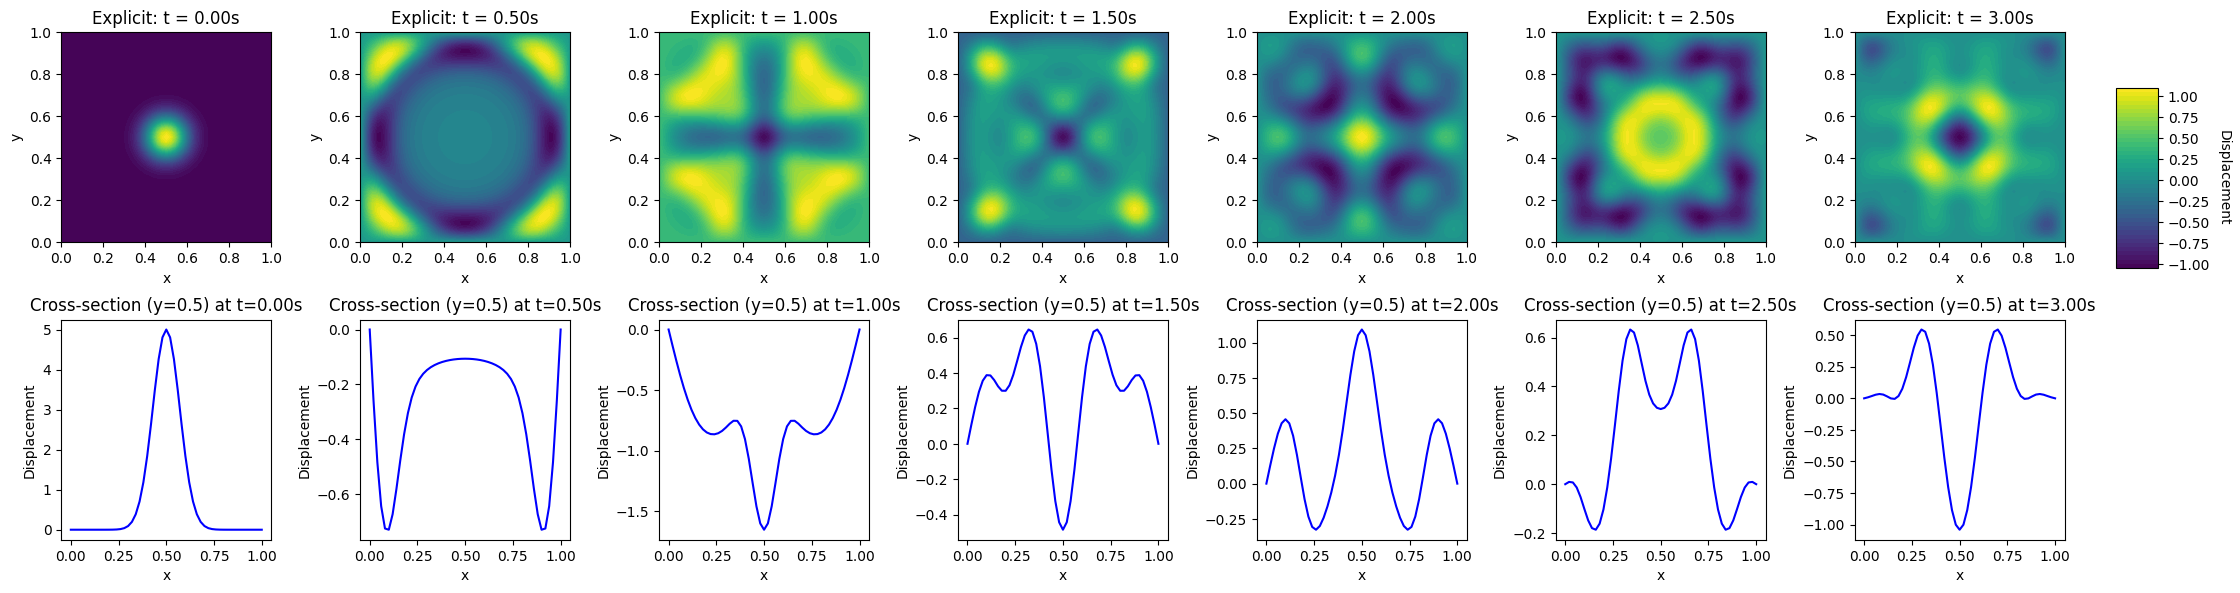

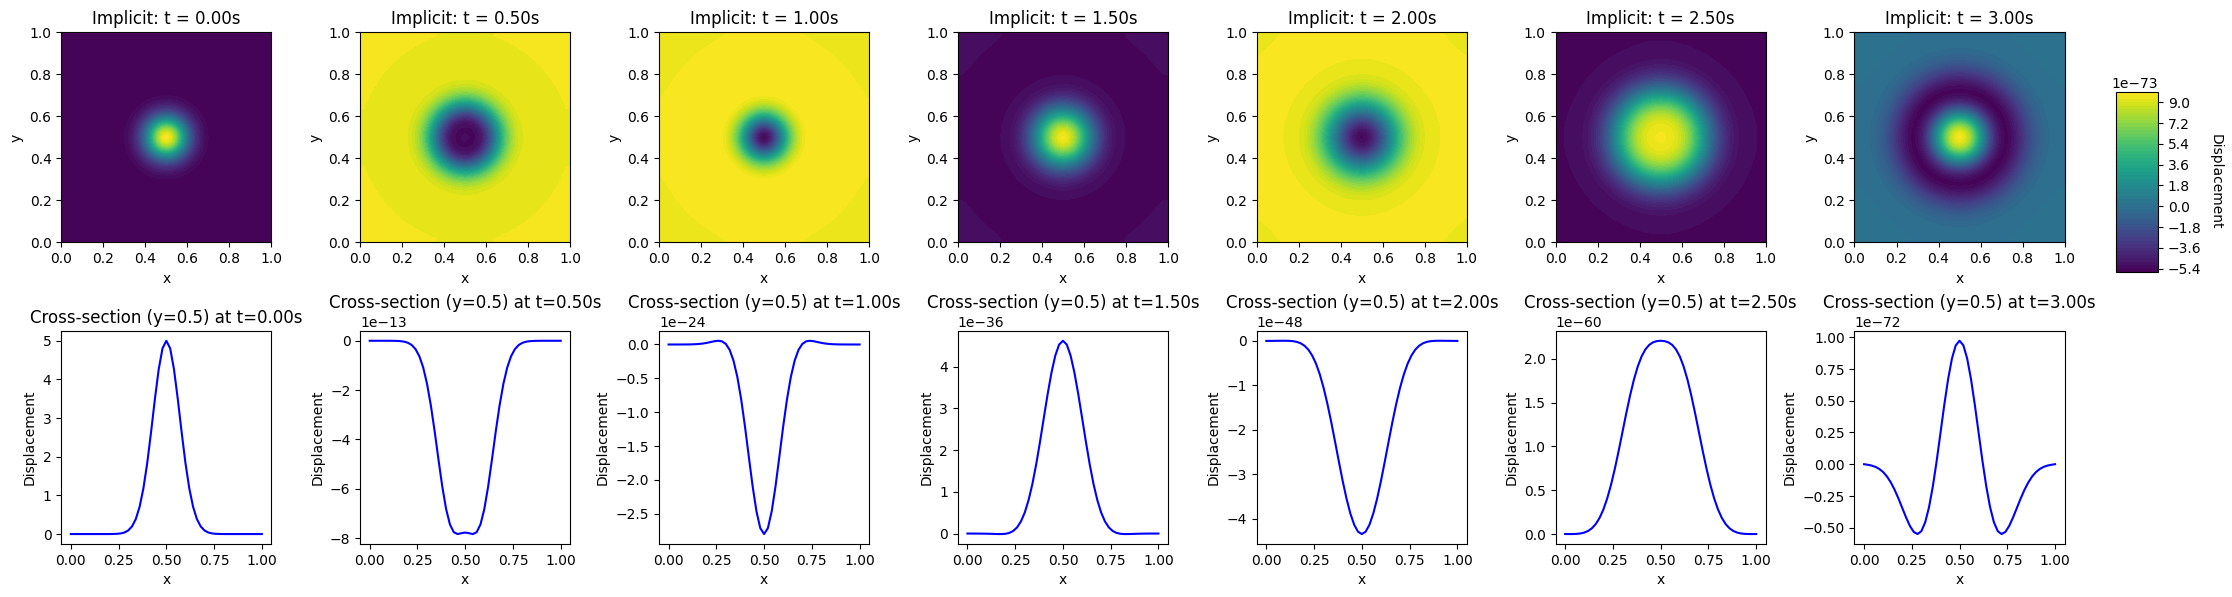

In [8]:
'Define parameters'
time_points = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0]
figsize = (3 * len(time_points), 6)

'Static visualisation for Explicit and Implicit Methods'
def static_plot(method, u, dt):
    fig, axs = plt.subplots(2, len(time_points), figsize=figsize)
    for i, t in enumerate(time_points):
        idx = int(t / dt)
        cp = axs[0, i].contourf(X, Y, u[idx, :, :], levels=50, cmap='viridis')
        axs[0, i].set_title(f'{method}: t = {t:.2f}s')
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('y')
        axs[0, i].set_aspect('equal', 'box')
        axs[1, i].plot(x, u[idx, :, ny // 2], color='b')
        axs[1, i].set_title(f'Cross-section (y=0.5) at t={t:.2f}s')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('Displacement')
    
    plt.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([1.01, 0.55, 0.02, 0.3])
    fig.colorbar(cp, cax=cbar_ax).set_label('Displacement', rotation=270, labelpad=15)
    plt.tight_layout()
    plt.show()

'Plot both graph'
static_plot("Explicit", u_exp, dt_exp)
static_plot("Implicit", u_impl, dt_impl)

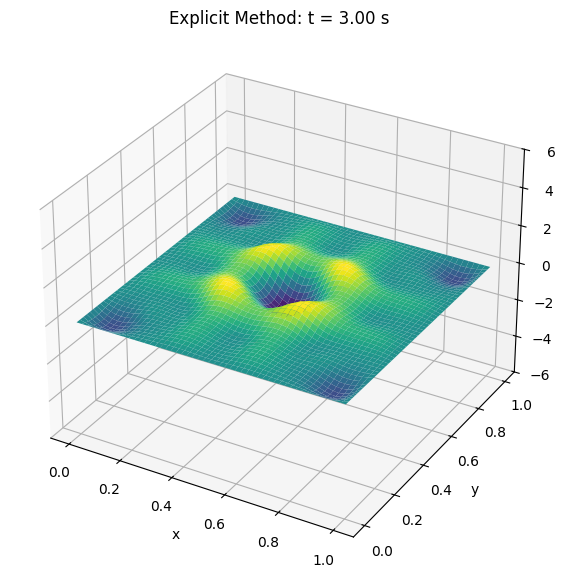

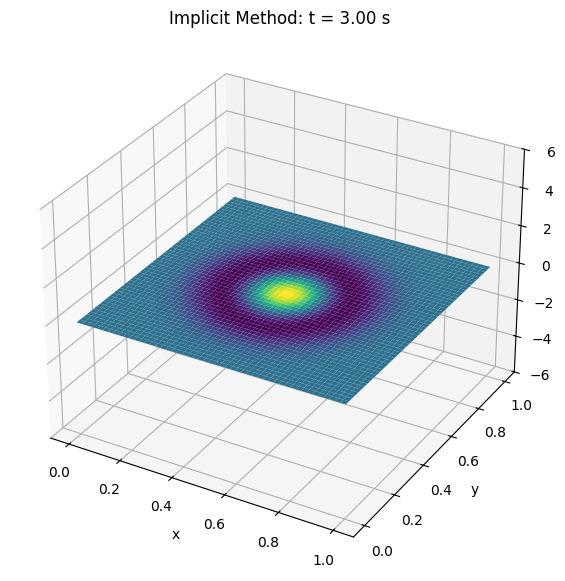

In [9]:
'Animated 3D surface plot function'
def animated_plot(method, u, dt, filename, interval, frame_per_sec):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Displacement')
    ax.set_zlim(-6, 6)

    def update(frame):
        ax.clear()
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('Displacement')
        ax.set_zlim(-6, 6)
        ax.plot_surface(X, Y, u[frame, :, :], cmap='viridis', rstride=1, cstride=1)
        ax.set_title(f"{method} Method: t = {frame * dt:.2f} s")
    
    ani = anim.FuncAnimation(fig, update, frames=range(0, len(u), 5), interval=interval)
    ani.save(filename, writer='pillow', fps= frame_per_sec, dpi=300)
    plt.show()

'Plot for both graphs'
animated_plot("Explicit", u_exp, dt_exp, "explicit_3d_animation.gif", interval=25, frame_per_sec=15)
animated_plot("Implicit", u_impl, dt_impl, "implicit_3d_animation.gif", interval=200, frame_per_sec=5)

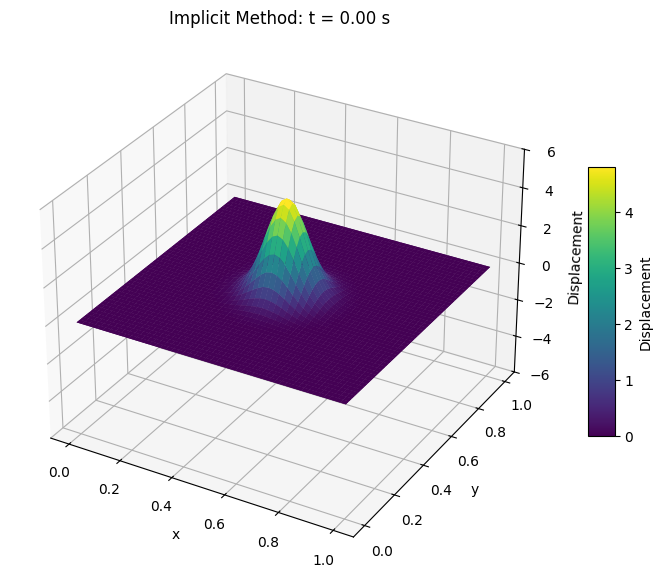

In [10]:
'3D Surface Plot at t=0 for Implicit Method'
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u_impl[0, :, :], cmap='viridis', rstride=1, cstride=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Displacement')
ax.set_title("Implicit Method: t = 0.00 s")
ax.set_zlim(-6, 6)
fig.colorbar(ax.plot_surface(X, Y, u_impl[0, :, :], cmap='viridis', rstride=1, cstride=1), shrink=0.5, aspect=10).set_label('Displacement')
plt.show()

#### In this section I am celebrating

In [11]:
print('CW done: I deserve a good mark')

CW done: I deserve a good mark
